In [1]:
# Использование библиотек
import osmnx as ox # основная библиотека для скачивания графа дорог и дальнейшей работы с ним
import networkx as nx # библиотека для работы с графом, почти не использовали, т.к. больше работали с osmnx
import numpy as np # для работы с матрицами
from random import random # для случайного выбора узлов и случайного назначения весов при заполнении матрицы расстояний
import json # для записи некоторых данных было удобнее использовать json формат
import csv # для записи полученной матрицы смежности и списков смежности графа
import matplotlib.pyplot as plt # для визуализации графа

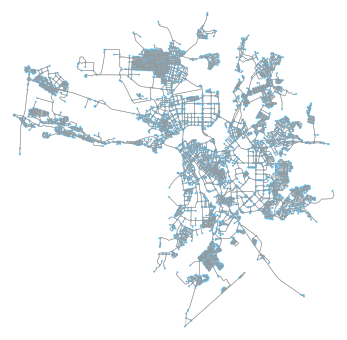

In [2]:
place = {'city' : 'Kazan',
         'country' : 'Russia'}
# наш граф
G = ox.graph_from_place(place, network_type='drive')


fig, ax = ox.plot_graph(G, edge_linewidth=0.5, node_size=4)

In [3]:
# в скаченном графе уже содержится информация о расстоянии между смежными вершинами
# находим их и сохраняем в словарь следующего вида:
# {id узла} : {{id смежной с ним вершины} : расстояние между ними} 
from pprint import pprint
a = G.adj
dictionary = {}
i = 0
for key, value in a.items():
    if i == 10:
        break
    for key_a, value_a in value.items():

        if key not in dictionary:
            dictionary[key] = [{key_a:value_a[0]['length']}]
        else:
            dictionary[key].append({key_a:value_a[0]['length']})                  
pprint(dictionary[76483453]) #просто вывод для одного из узлов, чтобы посмотреть на формат

[{654650848: 276.884}, {298140601: 454.7440000000001}]


In [4]:
nodes_list = list(G.nodes())

In [5]:
buildings = ox.footprints.footprints_from_place(place, footprint_type='building', retain_invalid=False, which_result=1)

In [6]:
hospital = []
apartments = []
n = 10000
build = buildings.head(n)['building'].to_dict()

for key,value in build.items():
    if value == 'hospital':
        hospital.append(key)
    elif value == 'apartments':
        apartments.append(key)

print(hospital[:10])
print(apartments[:100])

# получаем id больниц и домов, но они не являются узлами нашего графа
hospitals = hospital[:10]
apartments = apartments[:100]

[61424274, 61424329, 62040317, 62040327, 62040340, 72775188, 72775515, 72775583, 72775638, 72775692]
[56255883, 56255887, 56255889, 56255891, 56255892, 56255893, 56255896, 56255897, 56255898, 56255899, 56255900, 56255901, 56255906, 56255907, 56255910, 56255911, 56255912, 56255913, 56255914, 56255915, 61424177, 61424184, 61424186, 61424188, 61424193, 61424195, 61424197, 61424199, 61424203, 61424205, 61424206, 61424208, 61424209, 61424210, 61424213, 61424215, 61424229, 61424230, 61424235, 61424238, 61424246, 61424248, 61424250, 61424252, 61424256, 61424262, 61424264, 61424272, 61424280, 61424282, 61424284, 61424288, 61424290, 61424293, 61424300, 61424307, 61424309, 61424311, 61424313, 61424314, 61424315, 61424319, 61424322, 61424327, 61424332, 61424337, 61424338, 61424344, 61424348, 61424349, 61424362, 61424367, 61424373, 61424380, 61424381, 61424387, 61424389, 61424390, 61424392, 61424394, 61424396, 61424406, 61424410, 61424412, 61424416, 61424418, 61424420, 61424423, 61424428, 61424430

In [7]:
a = buildings.head(n).to_dict()
hospitals_dict = {}
apartments_dict = {}

print('Больницы')
for i in hospitals:   
    bounds = a['geometry'][i].bounds # это и есть географические координаты, точнее - полигон (не точные координаты объекта, а примерная область, которая его ограничивает)
    # поэтому берем среднее значение соответствующих координат (широты и долготы)
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    hospitals_dict[i] = nearest_node
    # соответствие id объекта с ближайшим узлом
    print(i, nearest_node)
print('------------------')
print('Апартаменты')
for i in apartments:
    bounds = a['geometry'][i].bounds    
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    apartments_dict[i] = nearest_node
    print(i, nearest_node)

Больницы
61424274 738200564
61424329 738200564
62040317 1430001830
62040327 775830916
62040340 773304756
72775188 411324758
72775515 411324765
72775583 861434955
72775638 1251018065
72775692 411324795
------------------
Апартаменты
56255883 730355743
56255887 295857558
56255889 484260741
56255891 484260736
56255892 484260739
56255893 534317522
56255896 419830632
56255897 534317522
56255898 419830632
56255899 419830632
56255900 730355768
56255901 295857558
56255906 534317530
56255907 534317530
56255910 3556716975
56255911 484262336
56255912 480690028
56255913 1174838843
56255914 446258388
56255915 1174839583
61424177 1967868583
61424184 847711650
61424186 739162326
61424188 1561540191
61424193 1571092305
61424195 1068922046
61424197 1806029749
61424199 739162327
61424203 1068922016
61424205 423155339
61424206 720459668
61424208 513783875
61424209 1967868578
61424210 972498348
61424213 766889336
61424215 1068922016
61424229 720459668
61424230 720459668
61424235 972498348
61424238 5137838

In [8]:
G_pd = nx.to_pandas_adjacency(G)

In [9]:
G_pd = G_pd.values

In [10]:
# список смежности
list_adjacency = {}
for i in range(len(G_pd)):
    temp = []
    for j in range (len(G_pd)):
        if G_pd[i][j] == 1:
            temp.append(j)
    list_adjacency[i] = temp

In [11]:
for i in range(len(G_pd)):
    for j in range(len(G_pd)):
        if G_pd[i][j] == 1:
            for k in range(len(dictionary[nodes_list[i]])):
                if nodes_list[j] in dictionary[nodes_list[i]][k].keys():
                    distance = dictionary[nodes_list[i]][k][nodes_list[j]]   
            weight = 1
#             if nodes_list[i] in hospitals_dict.values():
#                 weight = random() + 1
            G_pd[i][j] = distance * weight
# здесь нужно где 0 заполнить гигантскими расстояниями для дальнейшего нахождения кратчайших путей
        if G_pd[i][j] == 0:
            G_pd[i][j] = 1000000

In [12]:
# это делается для удобства, чтобы работать не с id узлами напрямую, а с их номером
nodes_numbers = {}
for index,i in enumerate(nodes_list):
    nodes_numbers[i]=index 
# nodes_numbers

In [14]:
nodes = [i for i in range(len(G_pd))]

In [18]:
def Dejicstra(a, b, matrix):
    # вершине соответствует длина пути до нее
    len_sh_way = {nd: 1000000 for nd in nodes}
    len_sh_way.update({a: 0})

    # кратчайший путь от вершины a
    shortest_way = {nd: [] for nd in nodes}
    shortest_way.update({a: [a]})

    current_node = a

    nd_to_visit = []  # ближайшие смежные
    deleted = []  # удаленные
    nd_to_visit.append(a)

    sort_len = []  # очередь с приоритетом: вес вершины - номер вершины
    while (1):
        if current_node != b:  # если не конечная вершина
            # делаем массив из весов оставшихся вершин
            sort_len = [len_sh_way.get(nd) for nd in nd_to_visit]
            # сортируем его, чтобы найти с наименьшим весом
            sort_len.sort()

            # ищем вершину с минимальным весом
            for key in nd_to_visit:
                if len_sh_way.get(key) == sort_len[0]:
                    # запоминаем ее
                    current_node = key
                    # добавляем в список удаленных
                    deleted.append(key)
                    break
            # получаем список вершин с которыми смежна текущая
            nd_to_vis = list(tuple(list_adjacency.get(current_node)))

            # добавляем их в список для посещения
            for nd in nd_to_vis:
                nd_to_visit.append(nd)
            # убираем повторения
            nd_to_visit = list(set(nd_to_visit))

            # новые вершины могут быть смежны с теми, которые удалили
            for nd in deleted:
                if nd_to_visit.count(nd) > 0:
                    nd_to_visit.remove(nd)

            for u in nd_to_visit:
                # для всех остальных вершин считаем вес (расстояние)
                weight = matrix[current_node][u]
                # если от нынешней вершины до нее ближе
                if len_sh_way.get(u) > len_sh_way.get(current_node) + weight:
                    w = len_sh_way.get(current_node) + weight
                    # перезаписываем длину
                    len_sh_way.update({u: w})

                    mas = list(tuple(shortest_way.get(current_node)))
                    mas.append(u)
                    m = list(tuple(mas))
                    # перезаписываем путь
                    shortest_way.update({u: m})

            if len(nd_to_visit) == 0:
                return shortest_way.get(b)
                break
        else:
            break

    return shortest_way.get(b)

In [29]:
l = Dejicstra(0, 4, G_pd)

In [22]:
def short_path_value(path, matrix):
    value = 0
    for i in range(len(path)-1):
        value += matrix[path[i]][path[i+1]]
    return value

value = short_path_value(l, G_pd)

In [23]:
value

9474.013

In [33]:
hospital_values = list(hospitals_dict.values())
apartments_values = list(apartments_dict.values())
hosp = nodes_numbers[hospital_values[0]]

In [34]:
new_nodes = apartments_values

In [35]:
index_nodes = [] # индексы узлов домов и квартир! и только их!
for i in new_nodes:
    index_nodes.append(nodes_numbers[i])

In [36]:
all_paths = {}
for i in range(len(new_nodes)):
    index = index_nodes[i]
    path = Dejicstra(hosp, index, G_pd)
    all_paths[index] = path

In [37]:
all_paths

{2498: [1327,
  5687,
  169,
  5698,
  2753,
  2352,
  2747,
  5417,
  4986,
  6642,
  4230,
  4809,
  7036,
  4196,
  4206,
  352,
  480,
  3928,
  3955,
  4359,
  4847,
  4846,
  4358,
  3133,
  3125,
  2503,
  2495,
  2497,
  2498],
 4845: [1327,
  5687,
  169,
  5698,
  2753,
  2352,
  2747,
  5417,
  4986,
  6642,
  4230,
  4809,
  7036,
  4196,
  4206,
  352,
  480,
  3928,
  3955,
  4359,
  4847,
  4846,
  4358,
  3133,
  3125,
  2503,
  2495,
  4845],
 6370: [1327,
  5687,
  169,
  5698,
  2753,
  2352,
  2747,
  5417,
  4986,
  6642,
  4230,
  4809,
  7036,
  4196,
  4206,
  352,
  480,
  3928,
  3955,
  4359,
  4847,
  4846,
  4358,
  3133,
  3125,
  2503,
  2495,
  4845,
  5946,
  6368,
  6370],
 6365: [1327,
  5687,
  169,
  5698,
  2753,
  2352,
  2747,
  5417,
  4986,
  6642,
  4230,
  4809,
  7036,
  4196,
  4206,
  352,
  480,
  3928,
  3955,
  4359,
  4847,
  4846,
  4358,
  3133,
  3125,
  2503,
  2495,
  4845,
  5946,
  2931,
  6365],
 6368: [1327,
  5687,
  169,
  5